# 2. Going beyond normality

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import pandas as pd
import scipy.stats as scs  #has easy functions for skewness and kurtosis

In [6]:
returns = pd.read_csv("data/data2_Portfolios_Formed_on_ME_EW_monthly.csv",
                     header=0, index_col=0,na_values=-99.99)  #FF decided -99.99 as the na values
columns = ['Lo 10','Hi 10']  
returns = returns[columns]
returns.columns = ['SmallCap','LargeCap']  #renaming the columns
returns = returns/100
returns.head()


,SmallCap,LargeCap
192607,-0.0142,0.0348
192608,0.0461,0.0352
192609,0.0091,0.0068
192610,-0.0472,-0.0237
192611,-0.0077,0.0268


In [9]:
#Calculate Skewness and Kurtosis
scs.skew(returns)

array([4.32602503, 0.21217585])

In [11]:
scs.kurtosis(returns) #This is actually the excess kurtosis= kurtosis - 3

array([43.26219757,  7.52011156])

## 1. Semi-deviation

In [12]:
returns.std()

SmallCap    0.105529
LargeCap    0.053829
dtype: float64

In [13]:
returns<0  #creates booleans

,SmallCap,LargeCap
192607,True,False
192608,False,False
192609,False,False
192610,True,True
192611,True,False
...,...,...
202107,True,False
202108,False,False
202109,True,True
202110,True,False


In [17]:
returns[returns<returns.mean()].std() #The standard deviation of the sub-sample of below-average returns

SmallCap    0.052185
LargeCap    0.040057
dtype: float64

In [19]:
returns[returns<0].std() #The standard deviation of the sub-sample of below-zero returns

SmallCap    0.051923
LargeCap    0.040267
dtype: float64

# 2. Value at Risk
## Historical VaR

In [22]:
np.percentile(returns, 5, axis=0)*-1 
#with 95 % confidence the monthly return will not lose more than 10.74% for the SmallCaps and 7.55% for LargeCaps.

array([0.10736, 0.07554])

## Parametric VaR

In [23]:
z = scs.norm.ppf(0.05) #ppf(q, loc=0, scale=1) Percent point function (inverse of ``cdf`` --- percentiles).
z

-1.6448536269514729

In [26]:
var_norm = -1*(returns.mean()+z*returns.std())
var_norm  #Try to compare with the historical VaR

SmallCap    0.155646
LargeCap    0.079383
dtype: float64

## Semi-parametric VaR

In [27]:
z = scs.norm.ppf(0.05)
s = scs.skew(returns[-120:])  #taking the last 120 months(rows) of returns
k = scs.kurtosis(returns[-120:])
z_cf = (z
        +(z**2-1)*s/6
        +(z**3-3*z)*k/24
        -(2*z**3-5*z)*(s**2)/36)
z_cf
        

array([-1.40135066, -1.73384688])

In [29]:
var_cf = -1*(returns[-120:].mean()+z_cf*returns[-120:].std())
var_cf

SmallCap    0.075827
LargeCap    0.054740
dtype: float64

## 3. Max Drawdown

In [30]:
# 1. Construct a wealth index: take the price time series and compute the value of buy-and-hold investment over time
returns.head(3)

,SmallCap,LargeCap
192607,-0.0142,0.0348
192608,0.0461,0.0352
192609,0.0091,0.0068


In [31]:
returns.index

Index([192607, 192608, 192609, 192610, 192611, 192612, 192701, 192702, 192703,
       192704,
       ...
       202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110,
       202111],
      dtype='int64', length=1145)

In [32]:
returns.index = pd.to_datetime(returns.index, format='%Y%m').to_period('M')
returns.index

PeriodIndex(['1926-07', '1926-08', '1926-09', '1926-10', '1926-11', '1926-12',
             '1927-01', '1927-02', '1927-03', '1927-04',
             ...
             '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07',
             '2021-08', '2021-09', '2021-10', '2021-11'],
            dtype='period[M]', length=1145)

In [33]:
returns.head(3)

,SmallCap,LargeCap
1926-07,-0.0142,0.0348
1926-08,0.0461,0.0352
1926-09,0.0091,0.0068


<Axes: title={'center': 'Wealth Index for Large Cap'}>

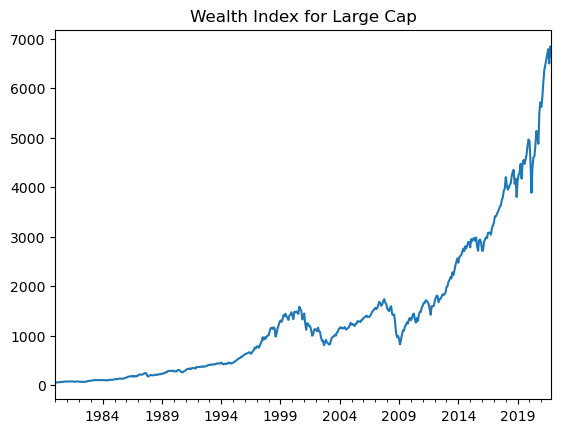

In [34]:
wealth = (1+returns['LargeCap']).cumprod()   # wealth index: the cumulative product of the returns during the period
wealth['1980':].plot(title= "Wealth Index for Large Cap")

<Axes: title={'center': 'Historical Peak for Large Cap'}>

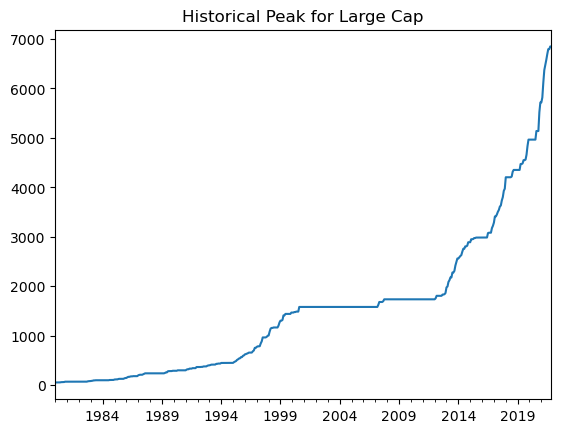

In [35]:
lastpeak = wealth.cummax()
lastpeak['1980':].plot(title="Historical Peak for Large Cap")

<Axes: title={'center': 'Drawdown for Large Cap'}>

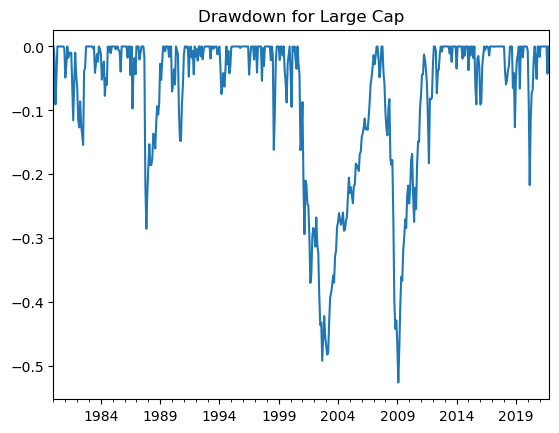

In [36]:
#Drawdown= Wealth -Peak (percentage of the wealth)
drawdown = (wealth - lastpeak)/lastpeak
drawdown['1980':].plot(title="Drawdown for Large Cap")

In [37]:
drawdown['1980':].min()

-0.5258438484161783

In [38]:
drawdown['1980':].idxmin()  #the index associated with the min value

Period('2009-02', 'M')

In [40]:
drawdown.idxmin()  #the great depression 1932(whole data max drawdown)

Period('1932-05', 'M')